In [1]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Apache Beam RunInference with Vertex AI

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_vertex_ai.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_vertex_ai.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This notebook shows how to use the Apache Beam [RunInference](https://beam.apache.org/releases/pydoc/current/apache_beam.ml.inference.base.html#apache_beam.ml.inference.base.RunInference) transform for image classification with [Vertex AI](https://cloud.google.com/vertex-ai).
Apache Beam has built-in support for sending requests to a remotely deployed Vertex AI endpoint by using the [`VertexAIModelHandlerJSON`](https://github.com/apache/beam/blob/395c4d15bb74351b0aa020dc7463de8d85766e07/sdks/python/apache_beam/ml/inference/vertex_ai_inference.py#L61) class. The input for this class is a JSON-serializable type, like a list.

When you use remote inference with Vertex AI, consider the following factors:
1. Public endpoints have a maximum request size of 1.5 MB. If you want to send larger requests, you must configure a [private endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints) and run your pipeline within the same VPC network. You might want to send larger requests if you send batches of requests.
2. Inputs to the Vertex AI model handler must be JSON serializable. If the inputs aren't JSON serializable, the request to the endpoint fails.
3. Hosting a model on Vertex AI and deploying it to an endpoint incurs cost from Google Cloud.

This notebook demonstrates the following steps:
- Configure access to a public Vertex AI endpoint.
- Set up example data.
- Run those examples with the built-in model handlers and get a prediction inside an Apache Beam pipeline.

For more information about using RunInference, see [Get started with AI/ML pipelines](https://beam.apache.org/documentation/ml/overview/) in the Apache Beam documentation.

## Before you begin
Set up your environment and download dependencies.

### Prerequisites
To run this notebook, first follow the steps for training a custom model in the Vertex AI ["Hello Custom Training"](https://cloud.google.com/vertex-ai/docs/tutorials/image-recognition-custom) tutorial. At minimum, you need to have a trained image classification model deployed to an endpoint within your Google Cloud project.

### Install Apache Beam
To use RunInference with the built-in Vertex AI model handler, install the Apache Beam SDK version 2.50.0 or later.

**Note:** The Apache Beam 2.50.0 SDK is currently in the release process and is not available. This notebook uses a release candidate build.

In [2]:
!pip install protobuf --quiet
!pip install apache_beam[gcp,interactive]==2.50.0 --quiet
# Enforce shapely < 2.0.0 to avoid an issue with google.aiplatform
!pip install shapely==1.7.1 --quiet

# To use the newly installed versions, restart the runtime.
exit()

### Authenticate with Google Cloud
This notebook relies on having a Vertex AI endpoint deployed to Google Cloud. To use your Google Cloud account, authenticate this notebook.

In [1]:
from google.colab import auth
auth.authenticate_user()

### Import dependencies and set up your bucket
Use the following code to import dependencies and to set up your Google Cloud Storage bucket.

Replace `PROJECT_ID`, `LOCATION_NAME`, and `ENDPOINT_ID` with the ID of your project, the GCP region where your model is deployed, and the ID of your Vertex AI endpoint.

In [ ]:
PROJECT_ID = "<PROJECT_ID>" # @param {type:'string'}
LOCATION_NAME = "<LOCATION_NAME>" # @param {type:'string'}
ENDPOINT_ID = "<ENDPOINT_ID" # @param {type:'string'}

### Query your Endpoint

Verify that your model is deployed to your Vertex AI endpoint. If you encounter errors, make sure that your endpoint is live and accessible from your current account.

In [3]:
aiplatform.init(project=PROJECT_ID_ID, location=LOCATION_NAME_NAME)
endpoint = aiplatform.Endpoint(endpoint_name=ENDPOINT_ID)
# To get more metadata, remove [0].display_name
endpoint.list_models()[0].display_name

'hello_custom'

### Preprocess an example image

Preprocess an input to match what your model expects. Use the following code to complete these steps:

1. Test the model by using an image of sunflowers.
2. Trim the image to 128x128 pixels to match the model's expectations.
3. Output the image as a list.

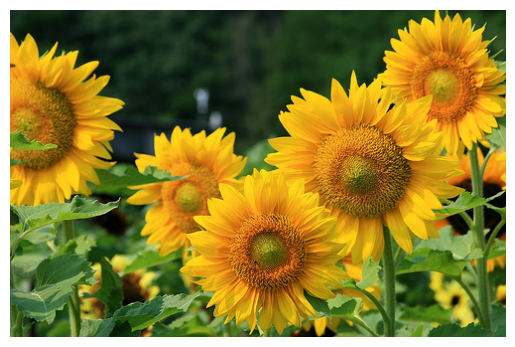

In [5]:
IMG_WIDTH = 128
IMG_URL = "https://storage.googleapis.com/apache-beam-ml/testing/inputs/vertex_images/sunflowers/1008566138_6927679c8a.jpg"

def download_image(image_url: str) -> bytes:
  return requests.get(image_url).content

def preprocess_image(data: bytes) -> List[float]:
  """Preprocess the image, resize it, and normalize it, and then
  convert it to a list.
  """
  image = tf.io.decode_jpeg(data, channels=3)
  image = tf.image.resize_with_pad(image, IMG_WIDTH, IMG_WIDTH)
  image = image / 255
  return image.numpy().tolist()

img = download_image(IMG_URL)
image = Image.open(BytesIO(img)).convert('RGB')
fig = plt.figure()
plt.axis('off')
plt.imshow(image)

## Run the pipeline
Use the following code to run the pipeline. The pipeline gets an image classification and a probability from the Vertex AI endpoint.

In [6]:
# Column labels for the output probabilities.
COLUMNS = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

class PostProcessor(beam.DoFn):
  def process(self, element: PredictionResult) -> Iterable[str]:
    prediction_vals = element.inference
    index = prediction_vals.index(max(prediction_vals))
    yield str(COLUMNS[index]) + " (" + str(max(prediction_vals)) + ")"

model_handler = VertexAIModelHandlerJSON(endpoint_id=ENDPOINT_ID, project=PROJECT_ID_ID, location=LOCATION_NAME).with_preprocess_fn(preprocess_image).with_preprocess_fn(download_image)

with beam.Pipeline() as p:
    _ = (p | beam.Create([IMG_URL])
           | RunInference(model_handler)
           | beam.ParDo(PostProcessor())
           | beam.Map(print)
        )

sunflowers (0.993382215)


## Use a keyed model handler
To use a keyed model handler, use `KeyedModelHandler` with Vertex AI by using `VertexAIModelHandlerJSON`.

By default, the `ModelHandler` does not expect a key.

* If you know that keys are associated with your examples, use `beam.KeyedModelHandler` to wrap the model handler.
* If you don't know whether keys are associated with your examples, use `beam.MaybeKeyedModelHandler`.

In [7]:
class PostProcessorKeyed(beam.DoFn):
  def process(self, element: Tuple[str, PredictionResult]) -> Iterable[str]:
    img_name, prediction_result = element
    prediction_vals = prediction_result.inference
    index = prediction_vals.index(max(prediction_vals))
    yield img_name + ": " + str(COLUMNS[index]) + " (" + str(
        max(prediction_vals)) + ")"

keyed_model_handler = KeyedModelHandler(VertexAIModelHandlerJSON(endpoint_id=ENDPOINT_ID, project=PROJECT_ID, location=LOCATION_NAME))
with beam.Pipeline() as p:
    _ = (p | 'CreateExamples' >> beam.Create([IMG_URL])
           | beam.Map(lambda img_name: (img_name, download_image(img_name)))
           | beam.MapTuple(lambda img_name, img: (img_name, preprocess_image(img)))
           | RunInference(keyed_model_handler)
           | beam.ParDo(PostProcessorKeyed())
           | beam.Map(print)
        )

https://storage.googleapis.com/apache-beam-ml/testing/inputs/vertex_images/sunflowers/1008566138_6927679c8a.jpg: sunflowers (0.993382215)
